# Variable Selection with CatBoost and Ridge Regression

This notebook performs variable selection using Ridge Regression and CatBoost on NBA betting data. We will train one model of each type on the comprehensive feature set and select important features based on their importance scores.

In [1]:
import glob
import numpy as np
import pandas as pd
import pickle
from functools import partial
from IPython.display import Image, display
from omegaconf import OmegaConf

from nba_ingame_prob.consts import proj_paths
from nba_ingame_prob.data.processing import add_prefix
from nba_ingame_prob.model.inputs import prepare_scalers
from nba_ingame_prob.training.linear import data_pipeline_linear
from nba_ingame_prob.training.mlflow_utils import ensure_experiment
from nba_ingame_prob.training.pipeline import prepare_data
from nba_ingame_prob.training.plotting import save_feature_importance_plots, separate_team_features
from nba_ingame_prob.training.trainers import train_linear_regression, train_catboost

In [2]:
team_stats_season = [
    'season_games',
    'season_wins', 'season_pts_for', 'season_pts_against',
    'season_wins_avg', 'season_pts_for_avg', 'season_pts_against_avg',
]
team_stats_last_5 = [
    'last_5_wins',
    'last_5_pts_for_avg', 'last_5_pts_against_avg',
    'last_5_pts_for_total', 'last_5_pts_against_total',
]

prefix_home = partial(add_prefix, prefix='home', return_type='list')
prefix_away = partial(add_prefix, prefix='away', return_type='list')

all_team_features = (
    prefix_home(team_stats_season) + prefix_away(team_stats_season) +
    prefix_home(team_stats_last_5) + prefix_away(team_stats_last_5)
)

target = ['final_score_diff']

data_params = {
    'seasons': 2,
    'seed': 66,
    'test_size': 0.2,
    'n': 20,
    'frac': None
}

data_prepared = prepare_data(**data_params)
scalers = prepare_scalers(data_prepared.X_train, all_team_features, proj_paths.output / 'scalers.pkl', fit_onehot_teams=True)

print(f"Training set shape: {data_prepared.X_train.shape}")
print(f"Test set shape: {data_prepared.X_test.shape}")
print(f"Features: {all_team_features}")

experiment_name = 'NBA-VariableSelection'
ensure_experiment(experiment_name)

linear_config = OmegaConf.create({
    'experiment_name': experiment_name,
    'model_name': 'lin_var_select',
    'inputs_team': all_team_features,
    'target': target,
    'data_params': data_params,
    'training': {
        'algorithm': 'linear_regression',
        'params': {
            'alpha': 1.0
        },
        'model_config': {
            'include_teams': True
        }
    }
})

catboost_config = OmegaConf.create({
    'experiment_name': experiment_name,
    'model_name': 'cb_var_select',
    'inputs_team': all_team_features,
    'target': target,
    'data_params': data_params,
    'training': {
        'algorithm': 'catboost_regressor',
        'params': {
            'learning_rate': 0.01,
            'random_state': 47,
            'colsample_bylevel': 0.5,
            'subsample': 0.5,
            'max_bin': 50,
            'max_depth': 8,
            'loss_function': 'RMSEWithUncertainty',
            'task_type': 'CPU',
            'iterations': 2000,
            'boosting_type': 'Plain',
            'bootstrap_type': 'Bernoulli',
            'verbose': 500
        },
        'model_config': {
            'include_teams': True,
            'unify_home_away': True
        }
    }
})

2025/09/27 23:31:14 INFO mlflow.tracking.fluent: Experiment with name 'NBA-VariableSelection' does not exist. Creating a new experiment.


Training set shape: (32460, 42)
Test set shape: (8120, 42)
Features: ['home_season_games', 'home_season_wins', 'home_season_pts_for', 'home_season_pts_against', 'home_season_wins_avg', 'home_season_pts_for_avg', 'home_season_pts_against_avg', 'away_season_games', 'away_season_wins', 'away_season_pts_for', 'away_season_pts_against', 'away_season_wins_avg', 'away_season_pts_for_avg', 'away_season_pts_against_avg', 'home_last_5_wins', 'home_last_5_pts_for_avg', 'home_last_5_pts_against_avg', 'home_last_5_pts_for_total', 'home_last_5_pts_against_total', 'away_last_5_wins', 'away_last_5_pts_for_avg', 'away_last_5_pts_against_avg', 'away_last_5_pts_for_total', 'away_last_5_pts_against_total']


In [3]:
print("Training Linear Regression...")
linear_result = train_linear_regression(linear_config, data_prepared, scalers, save_local_artifacts=False)
print(f"Model path: {linear_result.model_path}")
print(f"Run ID: {linear_result.run_id}")

if linear_result.model_path:
    with open(linear_result.model_path, 'rb') as f:
        linear_model_wrapper = pickle.load(f)

    X_processed, _ = data_pipeline_linear(
        data_prepared.X_train,
        scalers,
        all_team_features,
        include_teams=True,
        target='final_score_diff'
    )

    linear_coef = pd.Series(linear_model_wrapper.model.coef_, index=X_processed.columns)
    print("Linear Regression Coefficients:")
    print(linear_coef.sort_values(ascending=False))
else:
    print("ERROR: No model path returned!")

Training Linear Regression...


2025/09/27 23:31:14 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2025/09/27 23:31:15 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/09/27 23:31:15 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


🏃 View run Linear Regression (alpha=1) - 20250927-233114 at: http://mlflow:5000/#/experiments/215832187473002046/runs/54dd4a8c3c39416c9c3b745eb1f486fb
🧪 View experiment at: http://mlflow:5000/#/experiments/215832187473002046
Model path: /workspaces/nba-ingame-prob/output/temp_lin_model-20250927-233114-reg.pkl
Run ID: 54dd4a8c3c39416c9c3b745eb1f486fb
Linear Regression Coefficients:
score_diff                 9.209869
home_season_pts_for        5.538514
away_season_games          4.793385
away_MEM                   4.711460
home_GSW                   4.509504
                             ...   
away_IND                  -4.195637
away_BOS                  -4.724276
away_OKC                  -4.973419
home_WAS                  -5.068507
away_season_pts_against   -6.758623
Length: 86, dtype: float64


In [4]:
top_n = 10
linear_selected_features = linear_coef.abs().sort_values(ascending=False).head(top_n).index.tolist()
print(f"Top {top_n} features selected by Linear Regression:")
print(linear_selected_features)

threshold = 0.01
linear_important_features = linear_coef[linear_coef.abs() > threshold].index.tolist()
print(f"Features with |coef| > {threshold}: {len(linear_important_features)}")
print(linear_important_features)

Top 10 features selected by Linear Regression:
['score_diff', 'away_season_pts_against', 'home_season_pts_for', 'home_WAS', 'away_OKC', 'away_season_games', 'away_BOS', 'away_MEM', 'home_GSW', 'away_IND']
Features with |coef| > 0.01: 86
['home_season_games', 'home_season_wins', 'home_season_pts_for', 'home_season_pts_against', 'home_season_wins_avg', 'home_season_pts_for_avg', 'home_season_pts_against_avg', 'away_season_games', 'away_season_wins', 'away_season_pts_for', 'away_season_pts_against', 'away_season_wins_avg', 'away_season_pts_for_avg', 'away_season_pts_against_avg', 'home_last_5_wins', 'home_last_5_pts_for_avg', 'home_last_5_pts_against_avg', 'home_last_5_pts_for_total', 'home_last_5_pts_against_total', 'away_last_5_wins', 'away_last_5_pts_for_avg', 'away_last_5_pts_against_avg', 'away_last_5_pts_for_total', 'away_last_5_pts_against_total', 'score_diff', 'time_remaining', 'home_ATL', 'home_BKN', 'home_BOS', 'home_CHA', 'home_CHI', 'home_CLE', 'home_DAL', 'home_DEN', 'home_DE

In [5]:
print("Training CatBoost...")
catboost_result = train_catboost(catboost_config, data_prepared, scalers, save_local_artifacts=False)

fi_files = glob.glob(str(proj_paths.output / 'feature_importance-*-cat.csv'))
if fi_files:
    catboost_feature_importance = pd.read_csv(fi_files[-1], index_col=0).iloc[:, 0]
    print(f"Loaded CatBoost feature importance from: {fi_files[-1]}")
else:
    print("Warning: No CatBoost feature importance file found!")

Training CatBoost...


2025/09/27 23:31:16 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


0:	learn: -0.0287334	test: -0.0226743	best: -0.0226743 (0)	total: 74.5ms	remaining: 2m 28s
500:	learn: -0.6217632	test: -0.4752812	best: -0.4753397 (499)	total: 10.1s	remaining: 30.3s
1000:	learn: -0.7741699	test: -0.4320013	best: -0.4812638 (623)	total: 20.3s	remaining: 20.3s
1500:	learn: -0.8896665	test: -0.2433254	best: -0.4812638 (623)	total: 30.7s	remaining: 10.2s
1999:	learn: -0.9907075	test: 0.0091761	best: -0.4812638 (623)	total: 41.3s	remaining: 0us

bestTest = -0.4812637661
bestIteration = 623

Shrink model to first 624 iterations.


2025/09/27 23:31:58 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/09/27 23:31:59 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


🏃 View run CatBoost (lr=0.01, depth=8, iter=2000) - 20250927-233115 at: http://mlflow:5000/#/experiments/215832187473002046/runs/be0425df97684ffb9a2d40fa727c15f9
🧪 View experiment at: http://mlflow:5000/#/experiments/215832187473002046
Loaded CatBoost feature importance from: /workspaces/nba-ingame-prob/output/feature_importance-20250916-190228-cat.csv


Feature importance plots saved:
  - /workspaces/nba-ingame-prob/images/feature_importance_individual_models.png
  - /workspaces/nba-ingame-prob/images/feature_importance_top_combined.png


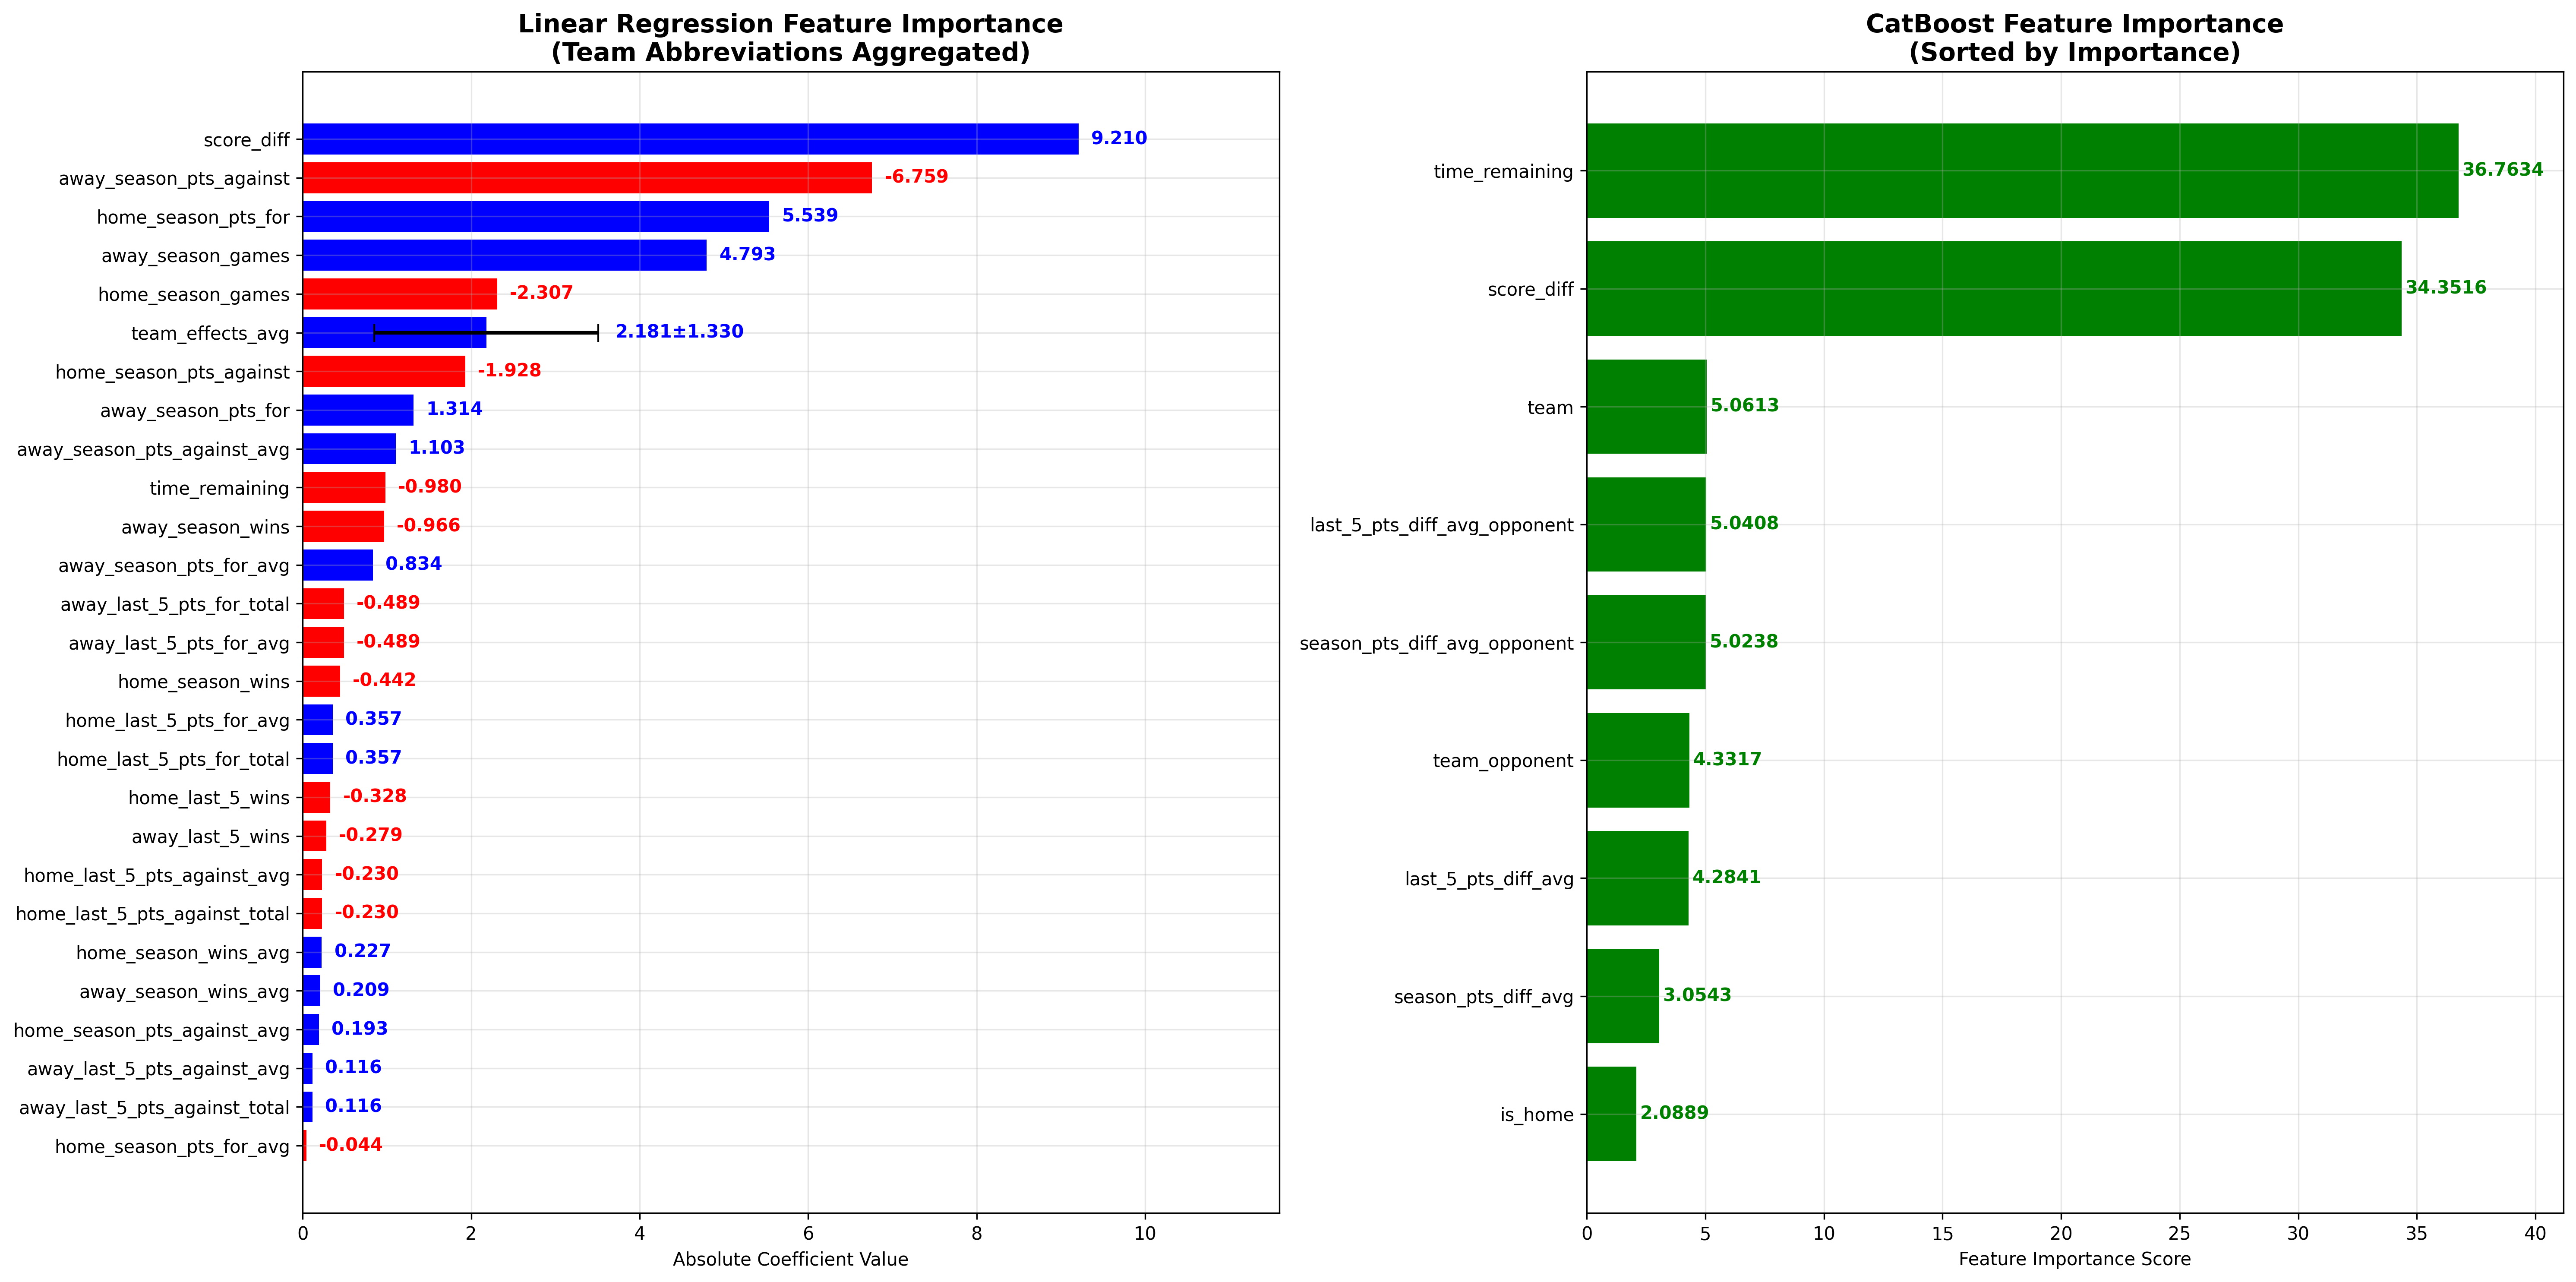

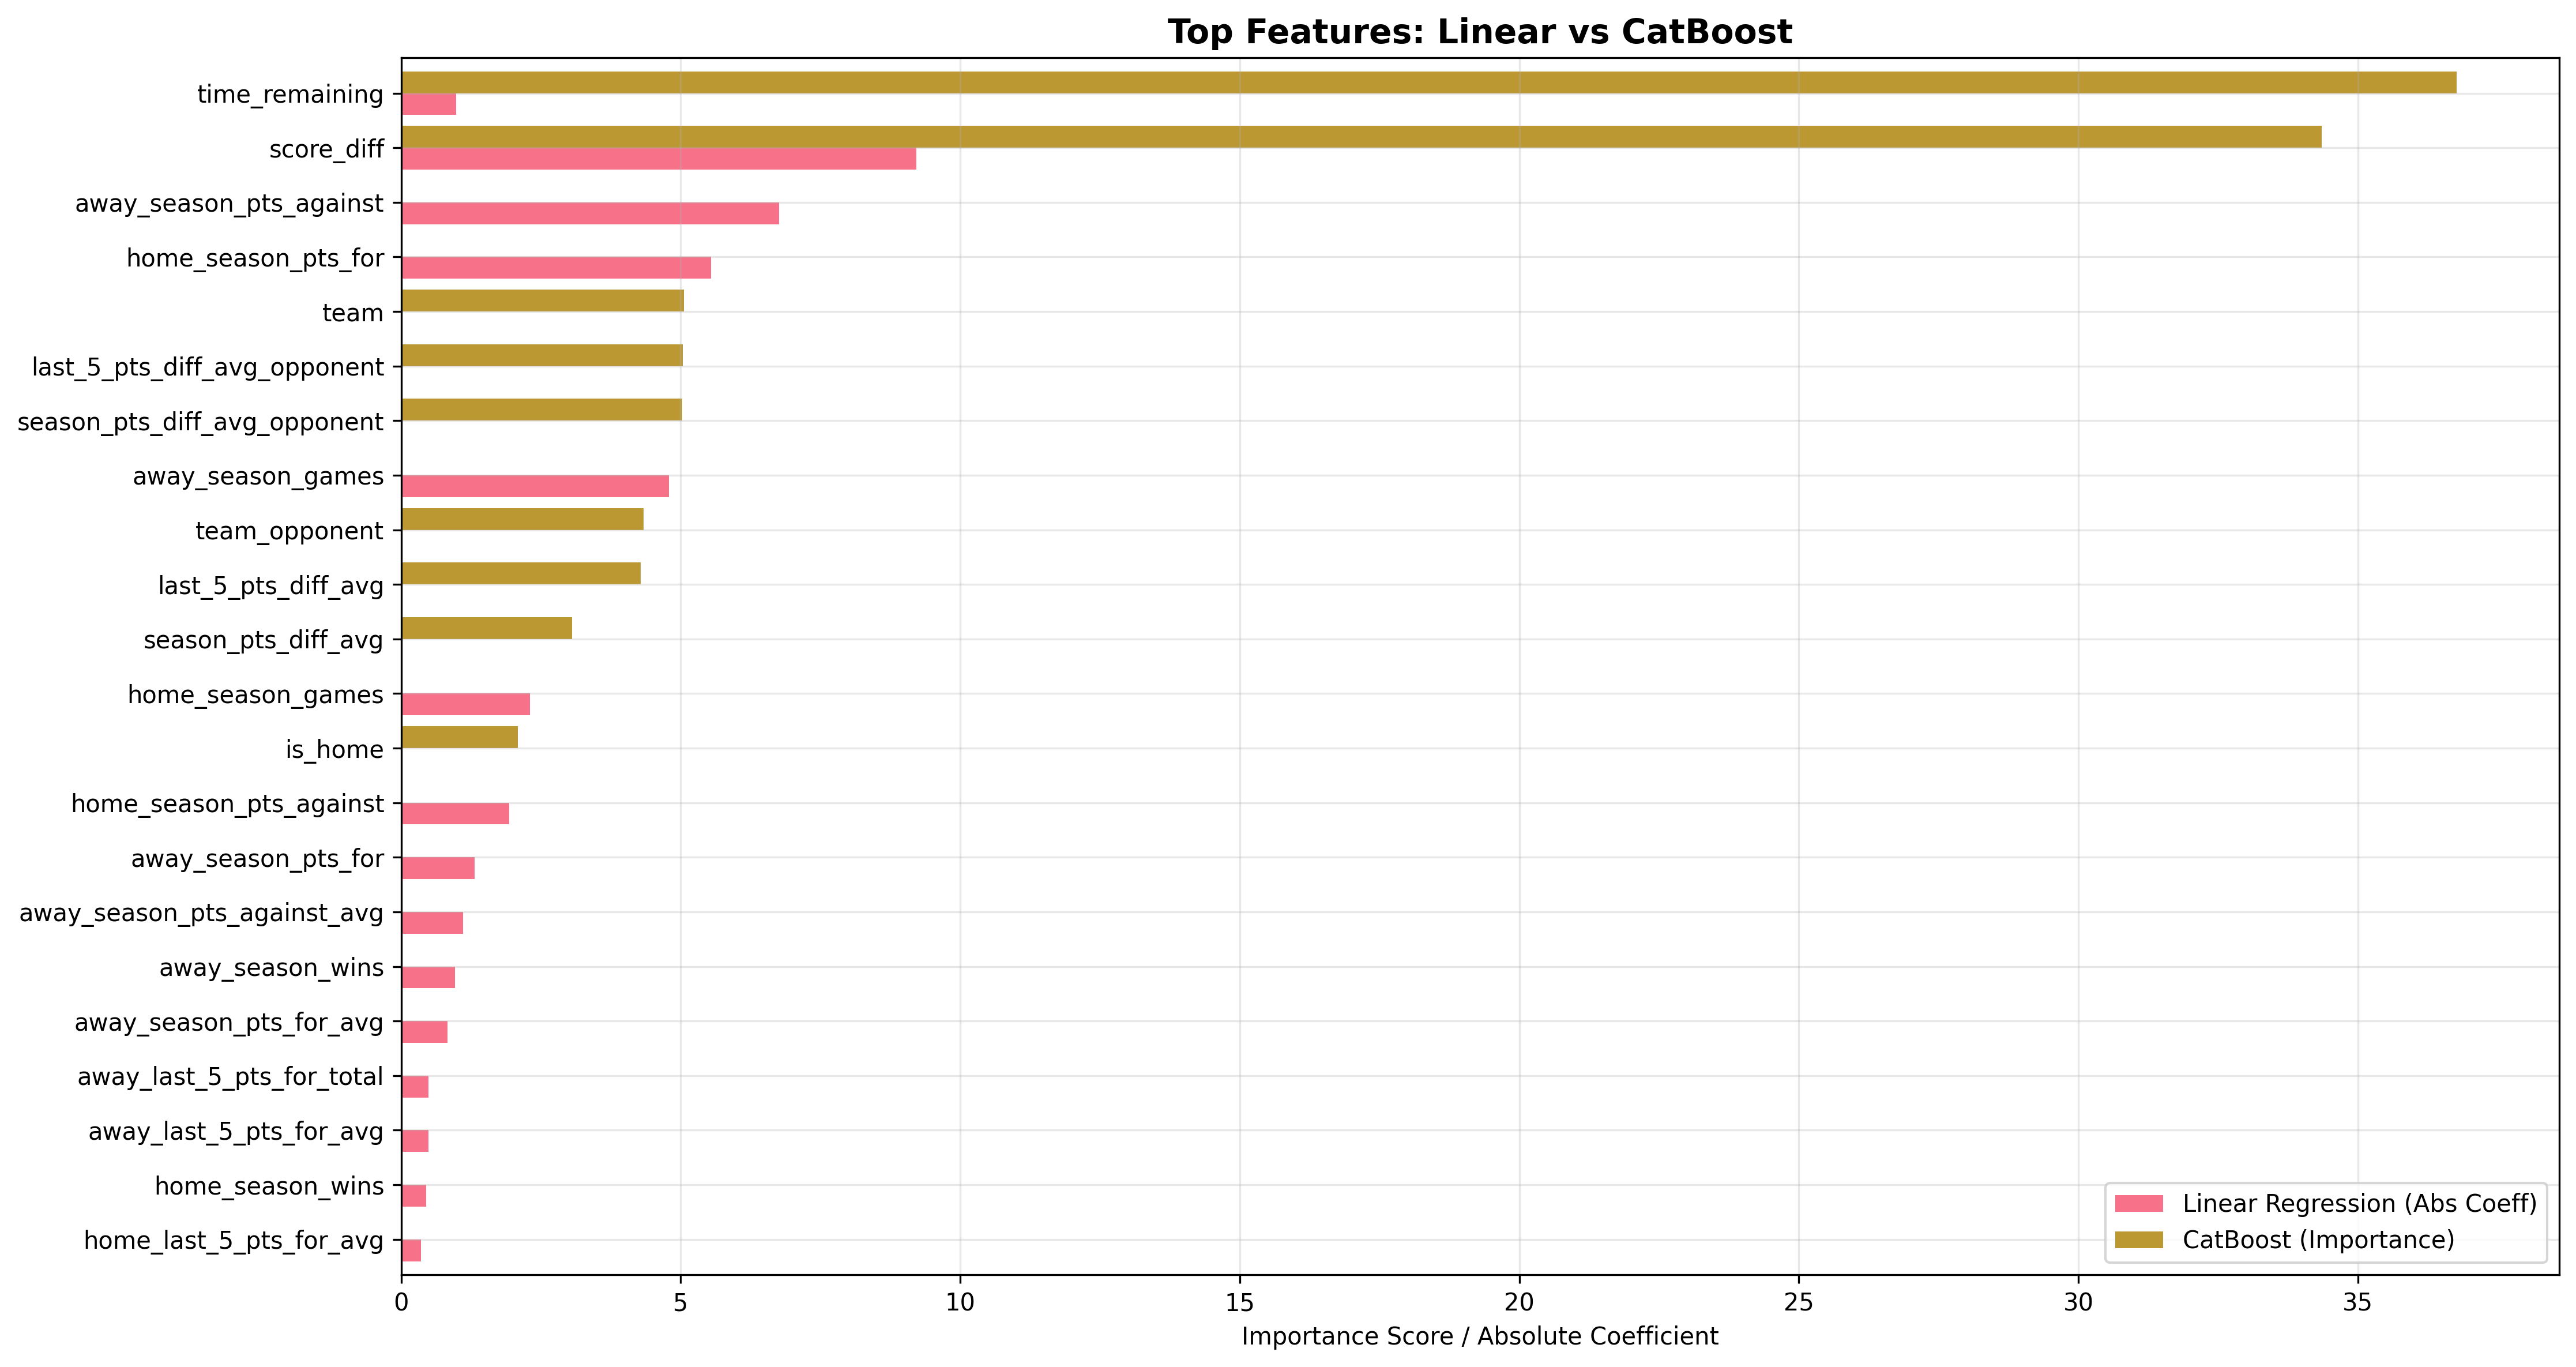


📊 LINEAR REGRESSION ANALYSIS:
--------------------------------------------------
Total features analyzed: 86
Team statistical features: 26
Team abbreviation features: 60

Team Abbreviation Effects Summary:
  Average effect: 2.1808
  Standard deviation: 1.3298
  Range: [0.8510, 3.5106]

Top 10 Team Statistical Features:
 1. score_diff                    : +9.2099
 2. away_season_pts_against       : -6.7586
 3. home_season_pts_for           : +5.5385
 4. away_season_games             : +4.7934
 5. home_season_games             : -2.3074
 6. home_season_pts_against       : -1.9281
 7. away_season_pts_for           : +1.3143
 8. away_season_pts_against_avg   : +1.1035
 9. time_remaining                : -0.9805
10. away_season_wins              : -0.9661

📊 CATBOOST ANALYSIS:
--------------------------------------------------
Total features analyzed: 9

Top 10 CatBoost Features:
 1. time_remaining                : 36.763419
 2. score_diff                    : 34.351647
 3. team           

In [6]:
images_dir = proj_paths.output.parent / 'images'
images_dir.mkdir(exist_ok=True)

plot_files = save_feature_importance_plots(
    catboost_importance=catboost_feature_importance,
    linear_coef=linear_coef,
    output_dir=images_dir,
    prefix="feature_importance"
)

print("Feature importance plots saved:")
for plot_file in plot_files:
    print(f"  - {plot_file}")

individual_plot = images_dir / 'feature_importance_individual_models.png'
if individual_plot.exists():
    display(Image(str(individual_plot)))

combined_plot = images_dir / 'feature_importance_top_combined.png'
if combined_plot.exists():
    display(Image(str(combined_plot)))

team_stats_coef, team_abbrev_coefs = separate_team_features(linear_coef)

team_effects_avg = np.mean(np.abs(team_abbrev_coefs)) if team_abbrev_coefs else 0
team_effects_std = np.std(np.abs(team_abbrev_coefs)) if team_abbrev_coefs else 0

print("\n📊 LINEAR REGRESSION ANALYSIS:")
print("-" * 50)
print(f"Total features analyzed: {len(linear_coef)}")
print(f"Team statistical features: {len(team_stats_coef)}")
print(f"Team abbreviation features: {len(team_abbrev_coefs)}")

print("\nTeam Abbreviation Effects Summary:")
print(f"  Average effect: {team_effects_avg:.4f}")
print(f"  Standard deviation: {team_effects_std:.4f}")
print(f"  Range: [{team_effects_avg - team_effects_std:.4f}, {team_effects_avg + team_effects_std:.4f}]")

print("\nTop 10 Team Statistical Features:")
top_team_stats = team_stats_coef.abs().nlargest(10)
for i, (feature, coef) in enumerate(top_team_stats.items(), 1):
    original_coef = team_stats_coef[feature]
    print(f"{i:2d}. {feature:<30}: {original_coef:+7.4f}")

print("\n📊 CATBOOST ANALYSIS:")
print("-" * 50)
print(f"Total features analyzed: {len(catboost_feature_importance)}")
print("\nTop 10 CatBoost Features:")
top_catboost = catboost_feature_importance.nlargest(10)
for i, (feature, importance) in enumerate(top_catboost.items(), 1):
    print(f"{i:2d}. {feature:<30}: {importance:.6f}")

# Conclusion

## Key Findings from Feature Importance Analysis

The feature importance analysis reveals several critical insights for NBA betting prediction:

### **Primary Drivers (Game Context)**
The most important features are **score difference** (9.21 coefficient) and **time remaining** (-0.98 coefficient), which capture the immediate game state. This aligns with intuition - the current score and time left are the strongest predictors of final outcomes.

### **Team Performance Metrics**
Both models identify team statistical features as highly predictive:
- **Defensive capabilities**: `away_season_pts_against` (-6.76) and related defensive metrics rank highly
- **Offensive capabilities**: `home_season_pts_for` (+5.54) shows strong importance
- **Overall team quality**: Season wins and recent form (last_5) provide valuable signals

### **Team Identity Effects**
Linear regression shows significant team-specific effects (average magnitude: 2.18 ± 1.33), indicating certain teams consistently perform above/below expectations. CatBoost handles this through its unified team representations.

### **Feature Selection Rationale**

Based on the analysis, we will prioritize:

1. **Game context features**: `score_diff`, `time_remaining` (universally important)
2. **Averages over totals**: To avoid overfitting to game count bias, we prefer averaged metrics
3. **Home/away distinction**: Separate home and away features capture location-specific effects
4. **Balanced offensive/defensive metrics**: Both `pts_for` and `pts_against` provide complementary information
5. **Recent vs season form**: Include both season averages and last_5 metrics for different time horizons

## **Features for Future Analysis:**

Based on the feature importance analysis, the following 16 features provide optimal predictive power while avoiding redundancy:

### Core Game Context (2 features):
- `score_diff` - Current score difference (most important feature)
- `time_remaining` - Time left in game (universally significant)

### Season Performance Averages (6 features):
- `home_season_pts_for_avg` - Home team offensive capability
- `away_season_pts_for_avg` - Away team offensive capability  
- `home_season_pts_against_avg` - Home team defensive capability
- `away_season_pts_against_avg` - Away team defensive capability
- `home_season_wins_avg` - Home team overall quality
- `away_season_wins_avg` - Away team overall quality

### Recent Form Indicators (6 features):
- `home_last_5_wins` - Home team recent momentum
- `away_last_5_wins` - Away team recent momentum
- `home_last_5_pts_for_avg` - Home team recent offensive form
- `away_last_5_pts_for_avg` - Away team recent offensive form
- `home_last_5_pts_against_avg` - Home team recent defensive form
- `away_last_5_pts_against_avg` - Away team recent defensive form

### Team Identity (2 features):
- `home_team_abbreviation` - For model-specific team effects
- `away_team_abbreviation` - For model-specific team effects

**Total: 16 features** (reduced from 24 original features)

This selection balances predictive power with model efficiency, capturing both immediate game state and underlying team capabilities while avoiding overfitting to game count biases.


Based on the feature importance analysis, the following 16 features provide optimal predictive power while avoiding redundancy:

### Core Game Context (2 features):
- `score_diff` - Current score difference (most important feature)
- `time_remaining` - Time left in game (universally significant)

### Season Performance Averages (6 features):
- `home_season_pts_for_avg` - Home team offensive capability
- `away_season_pts_for_avg` - Away team offensive capability  
- `home_season_pts_against_avg` - Home team defensive capability
- `away_season_pts_against_avg` - Away team defensive capability
- `home_season_wins_avg` - Home team overall quality
- `away_season_wins_avg` - Away team overall quality

### Recent Form Indicators (6 features):
- `home_last_5_wins` - Home team recent momentum
- `away_last_5_wins` - Away team recent momentum
- `home_last_5_pts_for_avg` - Home team recent offensive form
- `away_last_5_pts_for_avg` - Away team recent offensive form
- `home_last_5_pts_against_avg` - Home team recent defensive form
- `away_last_5_pts_against_avg` - Away team recent defensive form

### Team Identity (2 features):
- `home_team_abbreviation` - For model-specific team effects
- `away_team_abbreviation` - For model-specific team effects

**Total: 16 features** (reduced from 24 original features)

This selection balances predictive power with model efficiency, capturing both immediate game state and underlying team capabilities while avoiding overfitting to game count biases.